<h1 style="text-align: center">Implement Multi-Perception</h1>

# Import lib

In [13]:
import unittest
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Write Test Case

In [10]:
class TestFullyConnected(unittest.TestCase):
    
    def test_fc_init(self):
        fc = FC(n_in = 3, n_out = 5, activation = "sigmoid")
        self.assertEqual(fc.n_in, 3)
        self.assertEqual(fc.n_out, 5)
        self.assertEqual(fc.activation, "sigmoid")
        self.assertEqual(fc.W.shape, (3, 5))
        self.assertEqual(fc.dW.shape, (3, 5))
    
    def test_fc_forward(self):
        fc = FC(n_in = 3, n_out = 5, activation = "sigmoid")
        x = np.zeros((10, 3), dtype=np.float32)
        y = fc.forward(x)
        error = np.sum(np.abs((y - np.ones_like(y) * 0.5)))
        self.assertEqual(y.shape, (10, 5))
        self.assertLess(error, 1e-6)

    def test_fc_forward_identity(self):
        fc = FC(n_in = 3, n_out = 5, activation = None)
        x = np.zeros((10, 3), dtype=np.float32)
        y = fc.forward(x)
        error = np.sum(np.abs(y - np.zeros_like(y)))
        self.assertEqual(y.shape, (10, 5))
        self.assertLess(error, 1e-6)
        
    def test_fc_backward(self):
        fc = FC(n_in = 3, n_out = 5, activation = "sigmoid")
        x = np.zeros((10, 3), dtype=np.float32)
        y = fc.forward(x)
        dx = fc.backward(np.zeros_like(y))
        self.assertEqual(dx.shape, x.shape)
        self.assertEqual(fc.dW.shape, fc.W.shape)
    
    def test_fc_backward_identity(self):
        fc = FC(n_in = 3, n_out = 5, activation = None)
        x = np.zeros((10, 3), dtype=np.float32)
        y = fc.forward(x)
        dx = fc.backward(np.zeros_like(y))
        self.assertEqual(dx.shape, x.shape)
        self.assertEqual(fc.dW.shape, fc.W.shape)
    

In [11]:
class TestMultiPerceptron(unittest.TestCase):
    def test_mlp_init(self):
        mlp = MLP(n_ins = 3, hiddens = [5, 2])
        layer_0 = mlp.layers[0]
        layer_1 = mlp.layers[1]
        self.assertEqual(layer_0.W.shape, (3, 5))
        self.assertEqual(layer_1.W.shape, (5, 2))
        self.assertEqual(layer_1.activation, None)
        self.assertEqual(layer_0.activation, "sigmoid")
        
    def test_mlp_init(self):
        mlp = MLP(n_ins = 3, hiddens = [5, 2])
        layer = FC(n_in = 2, n_out = 1)
        mlp.add(layer)
        
        
    def test_mlp_forward(self):
        mlp = MLP(n_ins = 3, hiddens = [5, 2])
        x = np.zeros((10, 3))
        y = mlp.forward(x)
        self.assertEqual(y.shape, (10, 2))
    
    def test_mlp_backward(self):
        mlp = MLP(n_ins = 3, hiddens = [5, 2])
        x = np.ones((10, 3))
        mlp.forward(x)
        dy = np.ones((10, 2))
        dx = mlp.backward(dy)
        self.assertEqual(x.shape, (10, 3))

## Implement
### Fully Connected

In [204]:
class FC:
    def __init__(self, n_in, n_out, activation=None):
        self.n_in = n_in
        self.n_out = n_out
        
        self.activation = activation
        self.W = np.random.randn(self.n_in, self.n_out)
        self.dW = np.zeros_like(self.W)
        self.a = None
        self.f = None
        self.x = None
        
        
    @staticmethod
    def stable_sigmoid(X):
        return np.where(X >= 0,
                        1 / (1 + np.exp(-X)),
                        np.exp(X) / (1 + np.exp(X)))
  
    def __activation(self, a):
        if self.activation in (None, "linear"):
            f = a.copy()
        elif self.activation == "sigmoid":
            f = self.stable_sigmoid(a)
        else:
            raise NotImplementError(f"{self.activation} has been implemented yet")
            
        return f
    
    def __deactivation(self, output_grad, f):
        if self.activation in (None, "linear"):
            da = output_grad.copy()
        elif self.activation == "sigmoid":
            da = f * (1 - f) * output_grad
        else:
            raise NotImplementError(f"{self.activation} has been implemented yet")
            
        return da
        
    def forward(self, x):
        # x: N_samples x n_in
        # W: n_in x n_out
        self.x = x.copy()
        self.a = x @ self.W
        self.f = self.__activation(self.a)
        return self.f
    
    def backward(self, output_grad):
        # output_grad: n_samples x n_out
        da = self.__deactivation(output_grad, self.f)
        """"""
        # self.x: n_samples x n_in
#         self.dW = self.x.T @ self.da # expecting: n_in x n_out
        self.dW = np.einsum("ij,ik->jk", self.x, da)
        self.dx = da @ self.W.T # n_samples x n_in
        
        return self.dx
    
    def get_params(self):
        return np.array([self.dW])
    
    def training(self, learning_rate):
        self.W -= learning_rate * self.dW

## Multi - Perceptron

In [205]:
class MLP:
    def __init__(self, n_ins, hiddens, layers = None, learning_rate= .01, max_iterations = 1000):
        self.n_ins = n_ins
        self.hiddens = hiddens
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations 
            
        self.layers = [
            FC(n_in = self.n_ins if idx == 0 else self.hiddens[idx - 1],
               n_out = self.hiddens[idx],
               activation = "sigmoid" if idx + 1 != len(self.hiddens) else None) \
            for idx in range(len(self.hiddens))
        ]
        
        
    def forward(self, x):
        x_copy = x.copy()
        for layer in self.layers:
            x_copy = layer.forward(x_copy) 
        return x_copy

    def backward(self, output_grad):
        ograd_cp = output_grad.copy()
        for layer in self.layers[::-1]:
            ograd_cp = layer.backward(ograd_cp)
            layer.training(self.learning_rate)
        
        return ograd_cp
    
    def add(self, layer):
        assert(layer.n_in == self.layers[-1].n_out)
        if isinstance(layer, FC):
            self.layers.append(layer)
        else:
            raise NotImplementError("Not implement yet")
        
        
    def fit(self, X, y):
        # Specify SSE 
        n_samples = X.shape[0]
        losses = []
        for ite in range(self.max_iterations):
            y_hat = self.forward(X)
            e = y_hat - y
            loss = (e.T @ e)[0, 0]
            losses.append(loss)
            if ite % 100 == 0:
                print(f"Iteration: {ite}, Loss accuracy {loss}")

            
            self.backward(e)
        
        return loss
            

In [206]:
mlp = MLP(n_ins = 2, hiddens = [20,  1])

In [207]:
from sklearn.datasets import make_blobs

In [208]:
n_samples = 50

X, _ = make_blobs(n_samples = n_samples, n_features = 1)
y = (X ** 2 + 3 * X ).reshape(-1, 1)
X = np.c_[X, [1] * n_samples]
idx = np.random.permutation(n_samples)

X, y = X[idx], y[idx]
X_training , y_training = X[:int(0.8 * n_samples)], y[:int(0.8 * n_samples)]
X_test, y_test = X[int(0.8 * n_samples):], y[int(0.8 * n_samples):]


In [209]:
mlp.fit(X_training, y_training)

Iteration: 0, Loss accuracy 50184.12731099811
Iteration: 100, Loss accuracy 4422.721203560966
Iteration: 200, Loss accuracy 4543.956677563802
Iteration: 300, Loss accuracy 4239.0064021138105
Iteration: 400, Loss accuracy 4447.06895972842
Iteration: 500, Loss accuracy 4501.622481556783
Iteration: 600, Loss accuracy 4239.041683769878
Iteration: 700, Loss accuracy 4434.285404971257
Iteration: 800, Loss accuracy 4606.736679490606
Iteration: 900, Loss accuracy 4279.713752792479


4465.753933943337

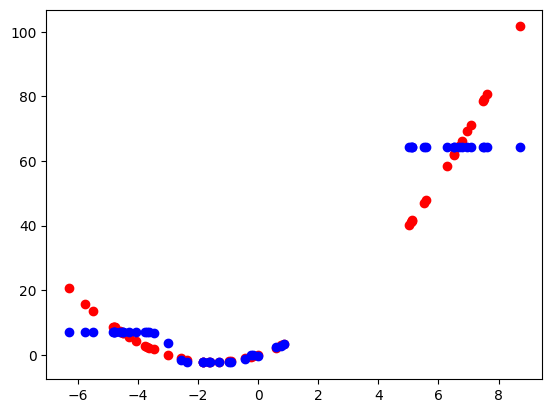

In [210]:
plt.scatter(X[:, 0], y, c="r")
plt.scatter(X[:, 0], mlp.forward(X) , c="b")

In [19]:
unittest.main(argv=[""], verbosity = 2, exit = False)

test_fc_backward (__main__.TestFullyConnected) ... ok
test_fc_backward_identity (__main__.TestFullyConnected) ... ok
test_fc_forward (__main__.TestFullyConnected) ... ok
test_fc_forward_identity (__main__.TestFullyConnected) ... ok
test_fc_init (__main__.TestFullyConnected) ... ok
test_mlp_backward (__main__.TestMultiPerceptron) ... ok
test_mlp_forward (__main__.TestMultiPerceptron) ... ok
test_mlp_init (__main__.TestMultiPerceptron) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.029s

OK


## Cơ sở toán học

### Tính toán đầu ra của mạng (tính xuôi)

Lặp $L$ lần, quy ước $\mathbf f_0 = \mathbf x$, với $l = 1,2,\ldots L$

$$ \begin{align*} \mathbf a_l &= \mathbf W_l \mathbf f_{l-1}\in\mathbb R^{p_l}\\ \mathbf f_l &= \phi_l(\mathbf a_l)\in\mathbb R^{p_l} \end{align*} $$

Tính logit, xác suất (softmax) và hàm lỗi cross-entropy

$$ \begin{align*} \mathbf f &= \mathbf f_L \in\mathbb R^{C}\\ \bf\mu &=\mathcal S(\mathbf f)\in\mathbb R^{C}\\ \ell &= -\mathbf y^T\log(\bf\mu)\in\mathbb R \end{align*} $$

$\mathbf y$ là **mã hoá one-hot** của nhãn $y\in\{1,2,\ldots, C\}$ .

Mạng nơ-ron có $L-1$ lớp ẩn và một lớp đầu ra.

### Lựa chọn hàm kích hoạt

- Hàm tuyến tính: $\phi_l(a) = a$, hay dùng ở lớp cuối cùng
- Hàm sigmoid: $\phi_l(a) = \sigma(a) = \frac 1 {1+e^{-a}}$, hay dùng ở các lớp trước lớp cuối cùng (lớp ẩn)
- Hàm ReLU: $\phi_l(a) = \max(0, a)$
- Hàm tanh: $\phi_l(a) = 2\sigma(a)-1$

💡 Nếu chọn $\phi_l(a) = a$ với mọi tầng của mạng thì sẽ có lại Hồi quy Logistics (trường hợp con của mạng nơ-ron)



### Suy luận bằng mạng nơ-ron

**Luật phân lớp**: chọn vị trí phần tử lớn nhất trong $\mathbf f$ là phân lớp của $\mathbf x$.

### Kích thước của bộ trọng số

- Đầu ra của tầng trước là đầu vào của tầng sau: ma trận $\mathbf W_l\in \mathbb R^{p_l\times p_{l-1}}$, trong đó $p_l$ là số đầu ra của lớp $l$ còn $p_{l-1}$ là số đầu ra của lớp $l-1$.
- Quy ước $p_0 = d+1$ là số đầu vào của mạng.
- Lớp cuối cùng: $p_L = C$ là số lớp của bài toán phân lớp.

### Đạo hàm của hàm lỗi (tính ngược)

#### B1. Tính đạo hàm $\delta_{\bf \mu}$

$$ \delta_{\bf\mu} = -\mathbf y^T / \bf\mu^T\in\mathbb R^{1\times C} $$

<aside> 💡 Lưu ý: vector hàng (dòng)

</aside>

#### B2. Tính đạo hàm $\mathbf J_{\bf\mu}(\mathbf f)$

$$ \begin{align*} \frac{\partial \mu_i}{\partial f_j} &= \frac{u'v-v'u}{v^2} =\frac{\mathbb I(i=j) e^{f_j}\sum_{c=1}^C e^{f_c}-e^{f_j}e^{f_i}}{(\sum_{c=1}^C e^{f_c})^2}\\ &= \mathbb I(i=j) \mu_j - \mu_i\mu_j=\begin{cases}(1-\mu_i)\mu_i&i=j\\-\mu_i\mu_j&i\neq j\end{cases}\\&=\begin{bmatrix}(1-\mu_1)\mu_1 &-\mu_2\mu_1 &\cdots&-\mu_K\mu_1\\ -\mu_1\mu_2&(1-\mu_2)\mu_2 &\cdots&-\mu_K\mu_2\\\vdots&\vdots&&\vdots\\-\mu_1\mu_K &-\mu_2\mu_K &\cdots&(1-\mu_K)\mu_K\end{bmatrix}\in\mathbb R^{C\times C} \end{align*} $$

#### B3. Tính đạo hàm $\delta_{\mathbf f}$

$$ \delta_{\mathbf f_L=}\delta_{\mathbf f} = \delta_{\bf\mu}\mathbf J_{\bf\mu}(\mathbf f)\in\mathbb R^{1\times C} $$

Trong trường softmax và cross-entropy thì $\delta_{\mathbf f} = \bf\mu^T-\mathbf y^T$.

#### B4. Tính đạo hàm $\mathbf J_{\mathbf f_l}(\mathbf a_l)$

Hàm tuyến tính $\phi_l(a) = a$ thì $\mathbf J_{\mathbf f_l}(\mathbf a_l)=\mathbf I\in\mathbb R^{p_l\times p_l}$

Hàm sigmoid $\phi_l(a) = \sigma(a)$ thì $\mathbf J_{\mathbf f_l}(\mathbf a_l)=\mathrm{diag}(f_{l1}(1-f_{l1}),f_{l2}(1-f_{l2}),\ldots,f_{lp_l}(1-f_{lp_l}))$

 💡 Do hàm kích hoạt được tính trên từng phần tử của $\mathbf a_l$ nên ma trận $\mathbf J_{\mathbf f_l}(\mathbf a_l)$ là ma trận đường chéo

#### B5. Tính đạo hàm $\mathbf J_{\mathbf a_l}(\mathbf f_{l-1})$

$$ \mathbf a_l = \mathbf W_l \mathbf f_{l-1} $$

$$ \mathbf J_{\mathbf a_l}(\mathbf f_{l-1}) = \mathbf W_l $$

#### B6. Tính đạo hàm của $\mathbf a_l$ đối với $\mathbf W_l$.

$$ \frac {\partial a_{li}}{\partial\mathbf W_l}=\begin{bmatrix}0 &0 &\cdots&0\\\vdots&\vdots&&\vdots\\ -&\mathbf f_{l-1}^T&-&-\\\vdots&\vdots&&\vdots\\0&0&\cdots&0\end{bmatrix}\in\mathbb R^{p_l\times p_{l-1}} $$

Ma trận gồm toàn các dòng số 0, duy nhất dòng thứ $i$ là đầu vào $\mathbf f_{l-1}^T$.

#### B7. Tính đạo hàm $\delta_{\mathbf a_l}, \delta_{\mathbf W_l}, \delta_{\mathbf f_{l-1}}$

$$ \begin{align*} \delta_{\mathbf a_l} &= \delta_{\mathbf f_l}\mathbf J_{\mathbf f_l}(\mathbf a_l)\in\mathbb R^{1\times p_l}\\ \delta_{\mathbf W_l} &= \delta_{\mathbf a_l}^T\mathbf f_{l-1}^T \in\mathbb R^{p_l\times p_{l-1}}\\ \delta_{\mathbf f_{l-1}}&=\delta_{\mathbf a_l}\mathbf W_l\in\mathbb R^{1\times p_{l-1}} \end{align*} $$

<aside> 💡 Công thức đầu tiên có ma trận đường chéo

</aside>

💡 Công thức thứ hai có được dựa vào đạo hàm thành phần $\frac{\partial \ell}{\partial\mathbf W_l}=\sum_{i=1}^{p_l}\frac{\partial\ell}{\partial a_{li}}\frac {\partial a_{li}}{\partial\mathbf W_l}$